# Flexible unsupervised binary change detection algorithm identifies phase transitions in continuous image streams

### Paul Chao <sup>1</sup> , Xianghui Xiao <sup>2</sup>, and Ashwin J. Shahani <sup>1</sup> 

<sup>1</sup> University of Michigan, Ann Arbor
<sup>2</sup> Brookhaven National Laboratory, Upton, NY

**Abstract**: Sequences of projection images collected during in-situ tomography experiments can capture the formation of
patterns in crystallization and yield their three-dimensional growth morphologies. These image streams generate
enormous and high dimensional datasets that span the full extent of a phase transition. Detecting from the continuous
image stream the characteristic times and temperatures at which the phase transition initiates is a challenge because
the phase change is often swift and subtle. Here we show a flexible unsupervised binary classification algorithm
to identify a change point during data intensive experiments. The algorithm makes a prediction based on statistical
metrics and has a quantifiable error bound. Applied to two in-situ X-ray tomography experimental datasets collected
at a synchrotron light source, the developed method can detect the moment at which the solid phase emerges from the
parent liquid phase upon crystallization and without performing computationally expensive volume reconstructions.
Our approach is verified using a simulated X-ray phantom and its performance evaluated with respect to solidification
parameters. The method presented here can be broadly applied to other big data problems where time series can be
classified without the need for additional training data.  

Keywords: Solidification, nucleation, machine learning, sinogram, x-ray tomography

## This notebook will detail the 'under the hood' operation of the method to determine the change point in a sinogram

In [607]:
import time
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from pathlib import Path
import h5py
import pandas as pd
import tomopy #for reconstruction purposes at the end
from scipy import ndimage
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from scipy.ndimage import median_filter

## Show the helper functions used

In [608]:
def prepare_sinogram(sinogram, period=3000, downsamplescale=10, numLiq=3, keepLiq=True):
    """
    prepare_sinogram will normalize the sinogram using the initial liquid scans

    Output: Sinogram that has been normalized.

    sinogram: The sinogram data as a 2D array
    period: The number of oprojections for a 360 degree sample rotation in a tomographic scan
    downsamplescale: the slice where the singoram will be extracted
    numLiq: The number of liquid periods to be used to normalize 
    keepLiq: If the output should contain the liquid frames used for normalization
    """
    sinogram = tomopy.minus_log(sinogram) # TODO
    sino_dwn = downsample(sinogram, scalingfactor=downsamplescale)
    period = int(period) // int(downsamplescale)
    sino_dwn_subliq = sub_sino_liq(sino_dwn,size=1,numLiq=numLiq, period=period, keepLiq=keepLiq)
    return sino_dwn_subliq 

def downsample(data, scalingfactor=10):
    """
    downsample will reduce the data size by a integer factor by summing a NxN sized pixel area

    Output: the downsampled data

    data: The sinogram data as a 2D array
    scalingfactor: The amount the data will be scaled
    """
    data = data[0:(data.shape[0] // scalingfactor)*scalingfactor , 0:(data.shape[1] // scalingfactor)*scalingfactor];
    rows = scalingfactor
    cols = scalingfactor
    smaller = data.reshape(data.shape[0]//rows, rows,  data.shape[1]//cols, cols).sum(axis=1).sum(axis=2)
    return smaller

def sub_sino_liq(data, numLiq, size=20, period=3000, keepLiq=True):
    """
    sub_sino_liq will normalize the singram using the liquid periods

    Output: the normalized sinogram

    data: The sinogram data as a 2D array
    period: The number of oprojections for a 360 degree sample rotation in a tomographic scan
    size (optional): The size of the  median filter used to filter the liquid region
    numLiq: The number of liquid periods to be used to normalize 
    keepLiq: If the output should contain the liquid frames used for normalization
    """
    liquid = np.zeros((period, data.shape[1]), dtype=np.float32)
    counter = 0
    for i in range(numLiq):
        liquid = liquid + data[counter*period: counter*period+period, :]
        counter += 1
    liquid = liquid/numLiq
    liquid = ndimage.median_filter(liquid, size)

    subtract_fluid_data = []
    for iblock in np.arange(0, data.shape[0], period):
        try:
            subtract_fluid_data.append(data[iblock:iblock + period] - liquid)
        except ValueError:
            remaining = data.shape[0] - iblock
            subtract_fluid_data.append(data[iblock:iblock + remaining] - data[:remaining])
    subtract_fluid_data = np.concatenate(subtract_fluid_data)

    if keepLiq == True:
        return subtract_fluid_data
    else:
        return subtract_fluid_data[numLiq*period:]

def digitizetolevels(data, nLevels=256):
    """
    digitizetolevels will scale the data to discrete levels

    Output: the digitized data

    data: The sinogram data as a 2D array
    nLevels: The number of levels to descretize to
    """
    _min, _max = (data.min(), data.max())
    bins = np.linspace(_min, _max, nLevels)
    data_digitized = np.digitize(data,bins,right=True)
    return data_digitized
    
def plotsino(sinogram, cmap='gray'):
    fig, ax = plt.subplots(figsize=(18, 2))
    ax.imshow(sinogram, cmap, interpolation='nearest', aspect='auto')
    fig.tight_layout()

# Create difference sino

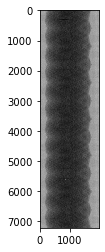

In [609]:
num_rotations = 5
layer = 1050

drive = "D"
fex_folder = drive+':/MyData/Uni Stuttgart/Masterarbeit/fex_data/'
g=h5py.File(fex_folder +'scan_00443_projections_00000.hdf', 'r')
projs_per_frame = 1202



def get_sino_full_rotation(frame_start, frame_end, layer, crop):
    return g['entry/data/data'][frame_start *projs_per_frame : frame_end*projs_per_frame, layer, crop:-crop]

def get_sino(frame_start, frame_end, layer, crop):
    sino = np.empty(((frame_end-frame_start),projs_per_frame//2, 1960), dtype=np.uint16)
    for frame in range(frame_start, frame_end):
        sino[frame] = g['entry/data/data'][frame *projs_per_frame : frame*projs_per_frame + projs_per_frame//2, layer, crop:-crop]
    sino = sino.reshape((frame_end-frame_start)*projs_per_frame//2, 1960)
    return sino

#s = get_sino(frame_start=0, frame_end=num_rotations+1, layer=layer, crop=300)
s = get_sino_full_rotation(frame_start=0, frame_end=num_rotations+1, layer=layer, crop=300)
#s1 = s[:-projs_per_frame]
#s2 = s[projs_per_frame:]

# minus log??
#s1 = tomopy.minus_log(s1.astype(np.int32))
#s2 = tomopy.minus_log(s2.astype(np.int32))

#s_d = abs(s1.astype(np.int32) - s2.astype(np.int32))#.astype(np.float32)

plt.imshow(s, cmap="gray")
plt.show()
#plt.imshow(s1, cmap="gray")
#plt.show()
#plt.imshow(s2, cmap="gray")
#plt.show()
#plt.imshow(s_d, cmap="gray")
#plt.show()

# Demostrating critical point determination using Case #1: Formation of quasicrystal

### 1. Import and normalize data

(7212, 1960)
 ** Time to and normalize: 0.13 seconds


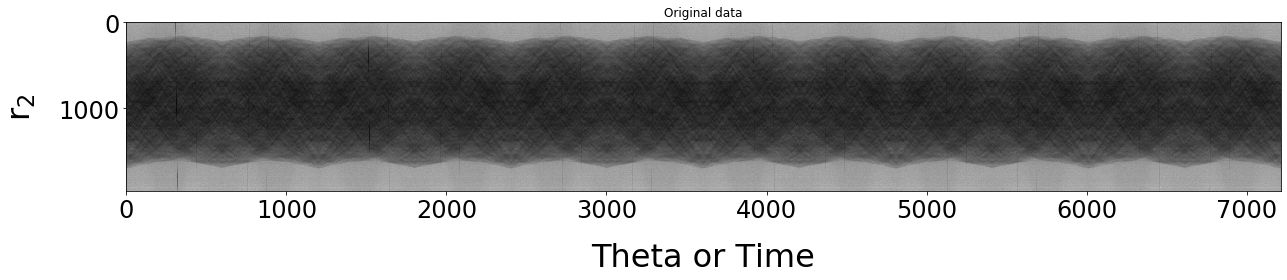

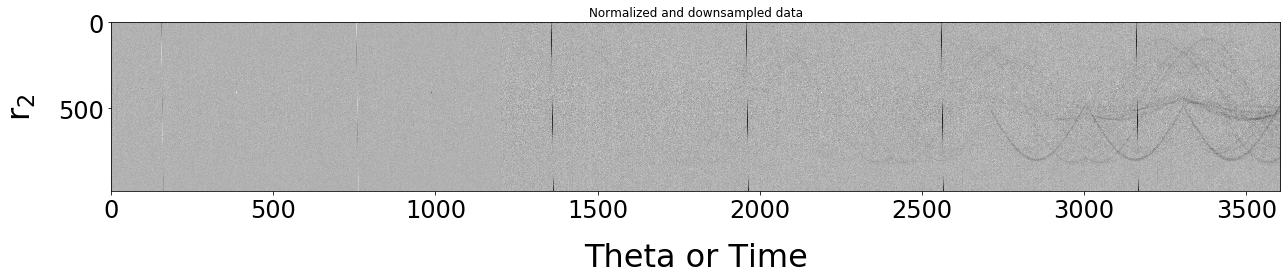

In [610]:
#Specify sample sinogram
#filename = 'data_QC_650.npy'
#filepath = os.path.join(sys.path[0], filename)

#filename = "sino_difference_00443_layer_0_num_rotations_4.npy"
#filepath = "E:/fex_data/sinos/"+filename

start_time = time.time()

#Import sinogram
sinogram_orig = s.astype(np.float32)#s_d#np.load(filepath)
print(sinogram_orig.shape)
#Define the number of projections in a 360 degree rotation
period = 1202#601#2000
downsamplescale = 2

#Normalize the sinogram
#sinogram = s_d
sinogram = prepare_sinogram(sinogram_orig, period=period, downsamplescale=downsamplescale, numLiq=2, keepLiq=True)
#print('File: ' + filepath)
print(' ** Time to and normalize: {:0.2f} seconds'.format(time.time()-start_time))

#Show the imported sinogram
fig, ax = plt.subplots(figsize=(18, 4))
ax.imshow(sinogram_orig.T, cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel("Theta or Time", fontsize = 32, labelpad=20)
ax.set_ylabel("r$_{2}$", fontsize = 32, labelpad=20)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_title("Original data")
fig.tight_layout()

#Show the normalized sinogram
fig, ax = plt.subplots(figsize=(18, 4))
ax.imshow(sinogram.T, cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel("Theta or Time", fontsize = 32, labelpad=20)
ax.set_ylabel("r$_{2}$", fontsize = 32, labelpad=20)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_title("Normalized and downsampled data")
fig.tight_layout()

#Optional: Save processed sinogram
#plt.savefig('Fig/F1.jpeg', format='jpeg', dpi=900)

data = digitizetolevels(sinogram)

In [611]:
from sinogram_functions import numUnique, maxDerivative_cols, numThreshold_ge, numThreshold_le

# Define the features to use 

df = pd.DataFrame({
    "index" : np.arange(data.shape[0]),
    #"Sum" : data.sum(axis=1),    
    #"Entropy"  : np.apply_along_axis(entropy2, 1, data),
    "Max value" : np.apply_along_axis(np.max, 1, data),
    "Min value" : np.apply_along_axis(np.min, 1, data),
    "Mean value" : np.apply_along_axis(np.mean, 1, data),
    "Median value" : np.apply_along_axis(np.median, 1, data),
    #"Q1" : np.quantile(data, .25, axis=1),
    #"Q3" : np.quantile(data, .75, axis=1),
    #"Standard Deviation" : np.apply_along_axis(np.std, 1, data),
    #"Range" : np.apply_along_axis(np.ptp, 1, data),
    "# of unique values" : np.apply_along_axis(numUnique, 1, data),
    #"SNR" : np.apply_along_axis(np.mean, 1, data)**2/np.apply_along_axis(np.std, 1, data)**2,
    #"Vals<200" : numThreshold_le(data, 200),
    #"Vals<150" : numThreshold_le(data, 150),
    #"Vals>150" : numThreshold_ge(data, 150),
    "# of values less than mean" : numThreshold_le(data, np.mean(data)),
    #"Vals>mean" : numThreshold_ge(data, np.mean(data)),
    #"max derivative 5" : maxDerivative_cols(data, distance=5),
    #"max derivative 50" : maxDerivative_cols(data, distance=50),
    #"max derivative 150" : maxDerivative_cols(data, distance=150),
    #"max derivative 10%" : maxDerivative_cols(data, distance=10),
    #"max derivative 50%" : maxDerivative_cols(data, distance=100),
    #"max derivative period" : maxDerivative_cols(data, distance=300),
    #"max derivative 1000" : maxDerivative_cols(data, distance=1000),
    #"max change period" : maxNegChange_period(data, distance=period),
    #"target" : makeTarget(visual_change, data.shape[0])
})



['Max value', 'Min value', 'Mean value', 'Median value', '# of unique values', '# of values less than mean']


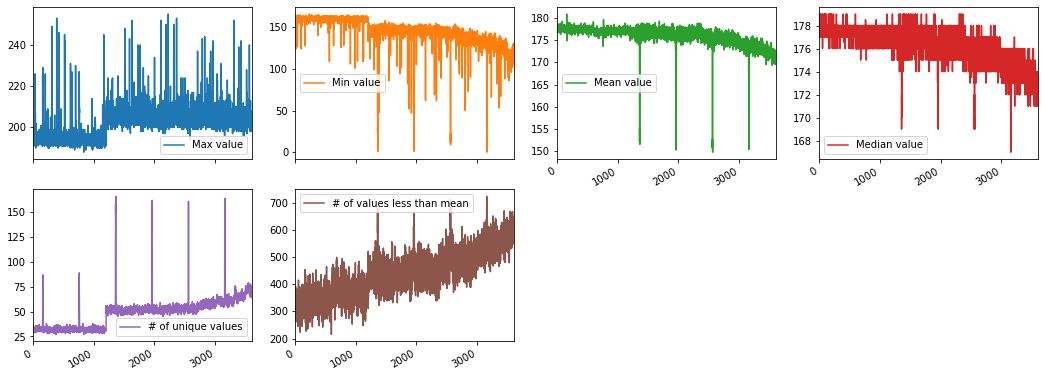

In [612]:
# Show trends for each feature
df_descriptors = pd.DataFrame.copy(df)
del df_descriptors['index']
print(list(df_descriptors.columns))

df_descriptors.plot(subplots=True, layout=(5,4),figsize=(18,18))
plt.axis('off')
plt.show()

### 2. Standardize data and perform PCA

In [613]:
# Set up the dataframe for PCA

#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
from sklearn.preprocessing import StandardScaler

features = list(df.columns[1:])
print(features)

# Separating out the features
x = df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

#set up as new dataframe
df_standard = pd.DataFrame(data=x,columns=features)

['Max value', 'Min value', 'Mean value', 'Median value', '# of unique values', '# of values less than mean']


In [614]:
# Perform PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 
                         'principal component 5', 'principal component 6'])


Total variance captured in first two componenets: 88.06


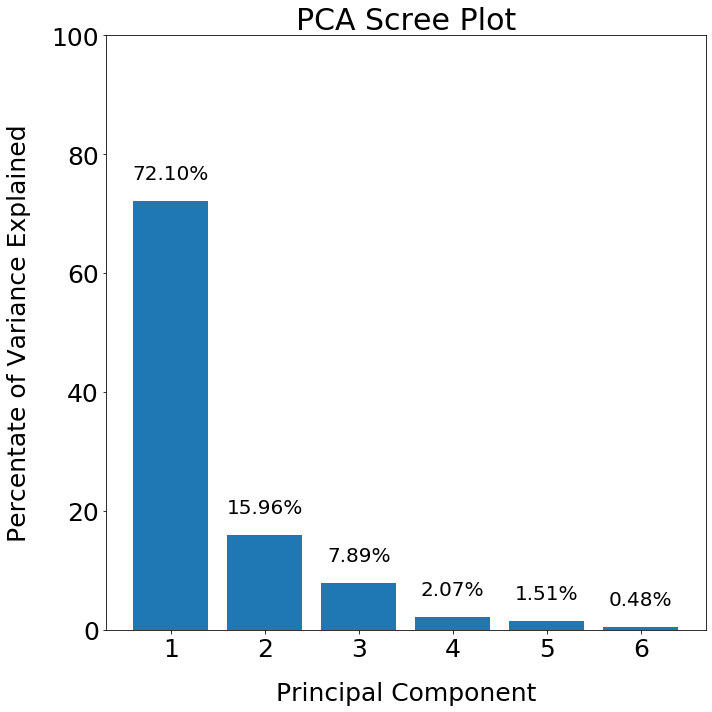

In [615]:
# Display Scree plot

var = pca.explained_variance_ratio_
percent_variance = np.round(var* 100, decimals =2)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 

ax.bar(x= range(1,7), height=percent_variance)#, tick_label=list(principalDf.columns))
ax.set_ylabel('Percentate of Variance Explained',  fontsize = 25, labelpad=20)
ax.set_ylim([0, 100])
ax.set_xlabel('Principal Component',  fontsize = 25, labelpad=20)
ax.set_title('PCA Scree Plot',  fontsize = 30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = var*100

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, "{:0.2f}%".format(label),
            ha='center', va='bottom', fontsize = 20)

    
print('Total variance captured in first two componenets: ' + "{:.2f}".format((var[0]+var[1])*100))

#Optional, save figure
#fig.savefig('Fig/scree.jpeg', format='jpeg', dpi=900)

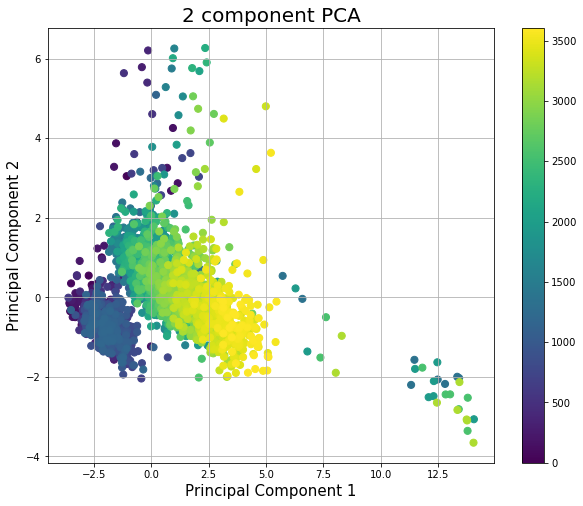

In [616]:
# Show results plotted in PCA space
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
pcaplot = ax.scatter(principalDf.loc[:,'principal component 1'], 
           principalDf.loc[:,'principal component 2'],
           c = range(principalDf.shape[0]), s = 50)
plt.colorbar(pcaplot, ax=ax)
ax.grid()

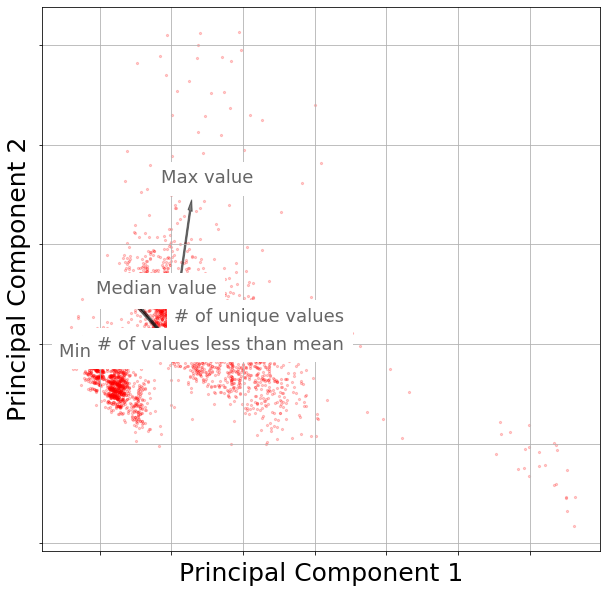

In [617]:
## Show feature contribution in pca space with a biplot

x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x)

def myplot(score,thresh,coeff,axis, labels=None):
    xs1 = score[:thresh,0]
    ys1 = score[:thresh,1]
    xs2 = score[thresh:,0]
    ys2 = score[thresh:,1]
    n = coeff.shape[0]
    axis.scatter(xs1, ys1, s = 5, alpha=0.2, color='red')
    axis.scatter(xs2, ys2, s = 5, alpha=0.2, color='blue')
    for i in range(n):
        axis.arrow(0, 0, coeff[i,0]* 3, coeff[i,1]* 3,color = 'black',alpha = 0.5, width=0.05)
    fsize = 18
    axis.text(coeff[0,0]* 3.5+0.5, coeff[0,1] * 3.5+0.2, labels[0], color = 'black',alpha = 0.6, ha = 'center', va = 'center', backgroundcolor = 'white', fontsize = fsize)
    axis.text(coeff[1,0]* 3.5-0.9, coeff[1,1] * 3.5-0.2, labels[1], color = 'black',alpha = 0.6, ha = 'center', va = 'center', backgroundcolor = 'white', fontsize = fsize)
    axis.text(coeff[2,0]* 3.5+0.9, coeff[2,1] * 3.5, labels[2], color = 'black',alpha = 0.6, ha = 'center', va = 'center', backgroundcolor = 'white', fontsize = fsize)
    axis.text(coeff[3,0]* 3.5+1, coeff[3,1] * 3.5+0.15 , labels[3], color = 'black',alpha = 0.6, ha = 'center', va = 'center', backgroundcolor = 'white', fontsize = fsize)
    axis.text(coeff[4,0]* 3.5+1.5, coeff[4,1] * 3.5-0.1, labels[4], color = 'black',alpha = 0.6, ha = 'center', va = 'center', backgroundcolor = 'white', fontsize = fsize)
    axis.text(coeff[5,0]* 3.5+0.2, coeff[5,1] * 3.5+0.2, labels[5], color = 'black',alpha = 0.6, ha = 'center', va = 'center', backgroundcolor = 'white', fontsize = fsize)

    axis.set_xlabel('Principal Component 1', fontsize = 25)
    axis.set_ylabel('Principal Component 2', fontsize = 25)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
    axis.grid()


#Call the function. Use only the 2 PCs.

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 

myplot(principalComponents[:,0:2],4109,np.transpose(pca.components_[0:2, :]), ax, labels=list(features))

#Optional, save figure
#fig.savefig('Fig/biplot.jpeg', format='jpeg', dpi=900)

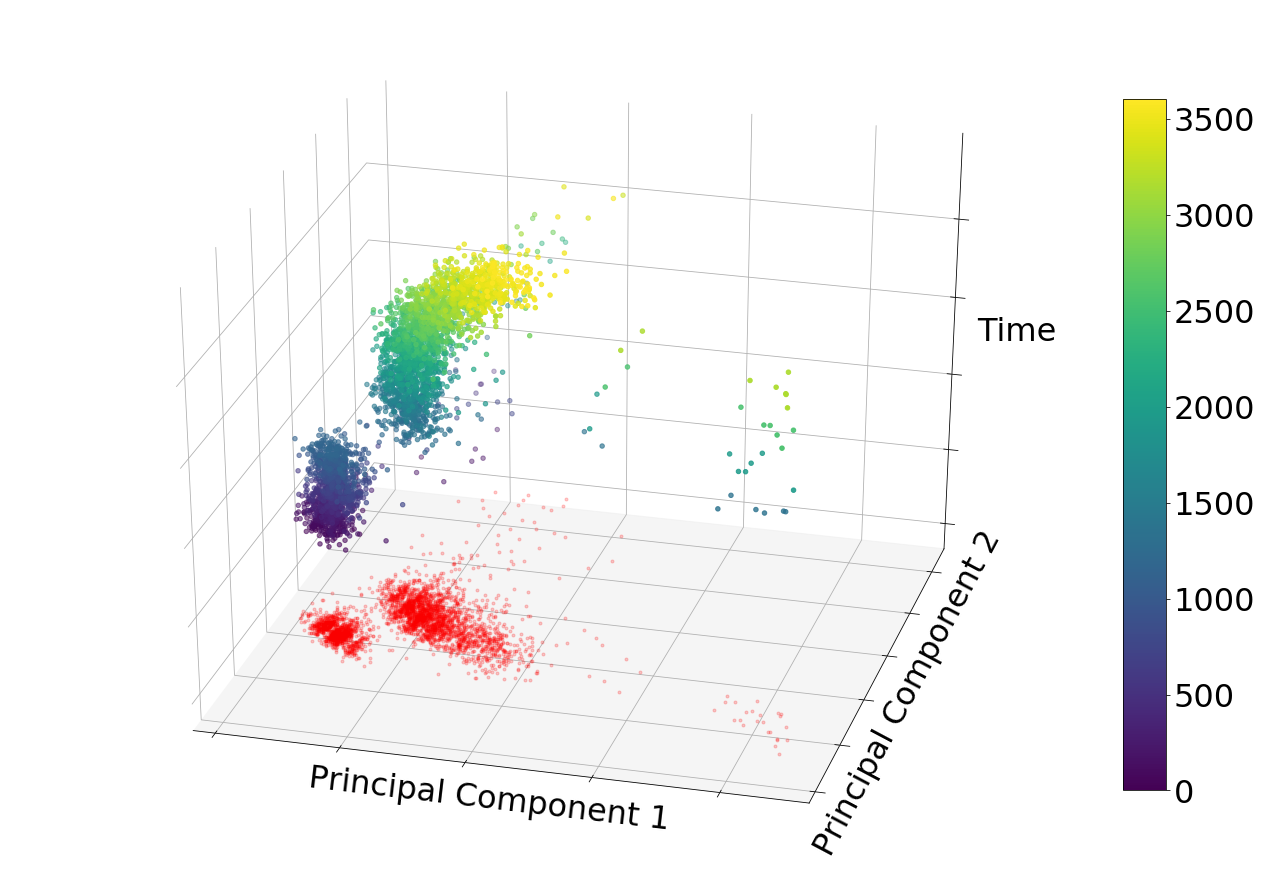

In [618]:
# Show PCA plot in a 3D perspective where the additional third axes is time
from mpl_toolkits.mplot3d import Axes3D

points = np.array(list(zip(principalDf.loc[:,'principal component 1'].values, principalDf.loc[:,'principal component 2'].values, df.loc[:,'index'].values)))

points = StandardScaler().fit_transform(points)

fig = plt.figure(figsize = (20,16))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 32)
ax.set_ylabel('Principal Component 2', fontsize = 32)
ax.set_zlabel('Time', fontsize = 32, labelpad=25)
#ax.set_title('2 component PCA', fontsize = 20)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
pcaplot = ax.scatter(points[:,0],points[:,1], points[:,2],
               c = range(points.shape[0]))
cbaxes = fig.add_axes([0.9, 0.2, 0.03, 0.6]) 
cbar = plt.colorbar(pcaplot, cax=cbaxes,fraction=0.03)
cbar.ax.tick_params(labelsize=32)
thresh = 4109

ax.plot(points[:thresh,0],points[:thresh,1], 'r.', alpha=0.2, zdir='z', zs=-3)
#ax.plot(points[thresh:thresh2,0],points[thresh:thresh2,1], 'g.', alpha=0.2, zdir='z', zs=-3)
ax.plot(points[thresh:,0],points[thresh:,1], 'b.', alpha=0.2, zdir='z', zs=-3)
ax.grid()
#ax.grid(which='z', color = 'black')
ax.view_init(elev=30., azim=-75)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

#fig.tight_layout()
#fig.savefig('Fig/pca.jpeg', format='jpeg', dpi=900)

### 3. Cluster PCA results

In [619]:
#Helper function
def argclosest(arr, K): 
      
     arr = np.asarray(arr) 
     idx = (np.abs(arr - K)).argmin() 
     return idx

In [620]:
import skfuzzy as fuzz

points = np.array(list(zip(principalDf.loc[:,'principal component 1'].values, principalDf.loc[:,'principal component 2'].values, df.loc[:,'index'].values)))
points = StandardScaler().fit_transform(points)

alldata = points.T
ncenters = 2

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 1.8, error=0.00005, maxiter=1000, init=None)
if int(period/10) % 2 == 0: windowsize = int(period/10+1)
else: windowsize = int(period) #Make it odd for the savgol filter
filtered_0 = savgol_filter(u[0,:], windowsize,1)
filtered_1 = savgol_filter(u[1,:], windowsize,1)

filtered_0 = medfilt(u[0,:], windowsize)
filtered_1 = medfilt(u[1,:], windowsize)

#if save: save_fuzzyProbability(u, filtered_0, filtered_1, 'fuzzyprob.png')

P = filtered_0[:-windowsize] * filtered_1[:-windowsize]

critical_pt = np.argmax(P)


(0, 8000)

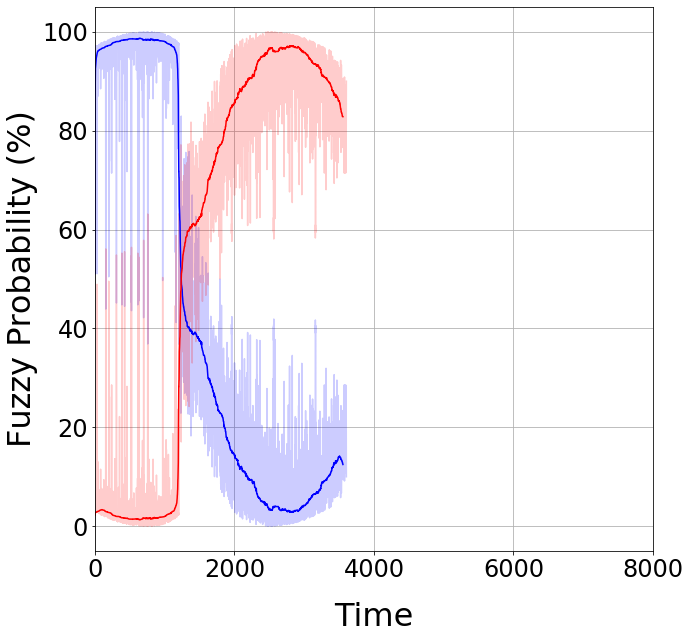

In [621]:
# Show fuzzy c-means cluster results

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 

#Median filter the fuzzy cluserting probability
filtered_0 = medfilt(u[0,:], 201)
filtered_1 = medfilt(u[1,:], 201)

#plot results
ax.plot(u[0,:]*100, alpha=0.2, color='blue')
ax.plot(u[1,:]*100, alpha=0.2, color='red')
ax.plot(filtered_0[:-50]*100, color='blue')
ax.plot(filtered_1[:-50]*100, color='red')
ax.set_xlabel("Time", fontsize = 32, labelpad=20)
ax.set_ylabel("Fuzzy Probability (%)", fontsize = 32)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.grid('on')
ax.set_xlim([0, 8000])

#Optional, save figure
#plt.savefig('Fig/fuzzy.jpeg', format='jpeg', dpi=900)

 *** Clustering Results
Critical point: 1233
Range of critical point (60% threshold): (1214, 1426)
Range of critical point (70% threshold): (1204, 1628)
Range of critical point (80% threshold): (1198, 1844)
 In the full dataset, time of critical point identified at: 2466
 In the downsampled dataset, time of critical point identified at: 1233


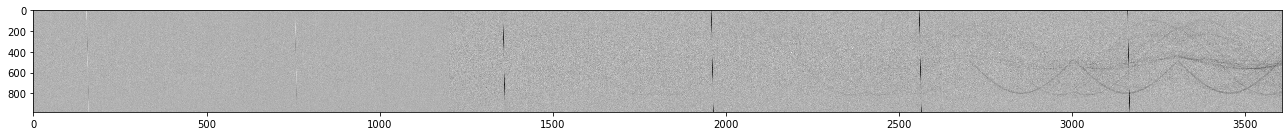

In [622]:
# Print probability bound results
print(' *** Clustering Results')
print('Critical point: {}'.format(critical_pt))
print('Range of critical point (60% threshold): ({0}, {1})'.format(
    argclosest(P[:critical_pt], 0.6*0.4), argclosest(P[critical_pt:], 0.6*0.4) + critical_pt ) )
print('Range of critical point (70% threshold): ({0}, {1})'.format(
    argclosest(P[:critical_pt], 0.7*0.3), argclosest(P[critical_pt:], 0.7*0.3) + critical_pt ) )
print('Range of critical point (80% threshold): ({0}, {1})'.format(
    argclosest(P[:critical_pt], 0.8*0.2), argclosest(P[critical_pt:], 0.8*0.2) + critical_pt ) )

print(' In the full dataset, time of critical point identified at: ' + str(critical_pt*downsamplescale))
print(' In the downsampled dataset, time of critical point identified at: ' + str(critical_pt))

plotsino(sinogram.T)

In [623]:
type(sinogram)
sinogram.shape

(3606, 980)

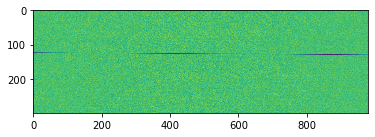

In [624]:
# Do tomographic reconstruction on identified critical point. We can use the normalized sinogram
# to obtain the necessary 180 rotation data needed, the projections required is half the downsampled period
data_at_criticalpt = sinogram[critical_pt:int(critical_pt+period/downsamplescale/2),:]

plt.imshow(data_at_criticalpt)

In [625]:
# define the theta, assume as equaly spaced 
theta = tomopy.angles(data_at_criticalpt.shape[0])

# determine rotation center
#rot_center = tomopy.find_center(data_at_criticalpt, theta, 125)
rot_center = 125

In [626]:
#Reconstruct the data
#Must add new axis to sinogram because a 3d array is expected
recon = tomopy.recon(np.expand_dims(data_at_criticalpt, axis=1), theta, center=125, algorithm='gridrec')

Reconstructing 1 slice groups with 1 master threads...


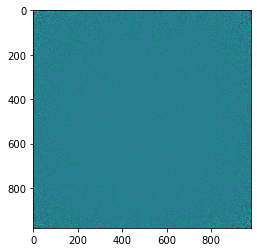

In [627]:
plt.imshow(np.squeeze(recon))
plt.show()